# Worked Examples and Exercises from Chapter 4 of *Essential Math for Data Science*

## Linear Regression, the chapter we've all been waiting for

This chapter provides an excellent overview of basic linear regression including all of those equations I was tested on and then promptly forgot in grad school. One flaw in this chapter, or maybe it's a good thing, is that it's not really about best practice as far as coding regression and more about coding out the underlying mechanics of regression. Ok, this is not a flaw, it's good, but I do think there's a value to unpacking scikit-learn or whatever and connecting it to some of these broader concepts.

1. Perform a simple linear regression to find m and b values that minimizes the loss (sum of squares).

In [9]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# bring in the data
df = pd.read_csv("https://raw.githubusercontent.com/thomasnield/machine-learning-demo-data/master/regression/linear_normal.csv")

In [3]:
# let's take a look at what we're working with
df.head()

,x,y
0,1,-13.115843
1,2,25.806547
2,3,-5.017285
3,4,20.256415
4,5,4.075003


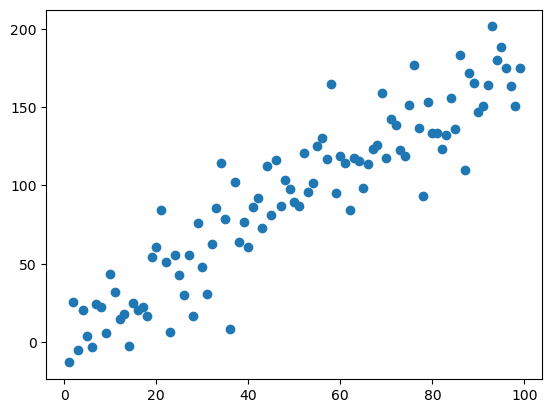

In [6]:
# let's take a peak at the data visually
import matplotlib.pyplot as plt

plt.plot(df["x"], df["y"], 'o')

In [12]:
# let's set up our model

X = df.values[:, :-1]
Y = df.values[:, -1]

# fit a model!

fit = LinearRegression().fit(X, Y)

In [13]:
m = fit.coef_.flatten()
b = fit.intercept_.flatten()

print("m = {0}".format(m))
print("b = {0}".format(b))

m = [1.75919315]
b = [4.69359655]


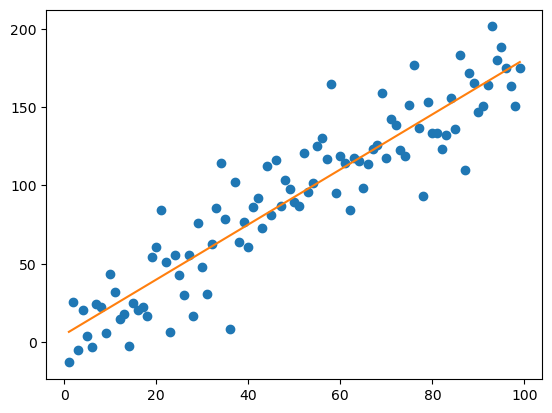

In [15]:
# let's look at the same plot, but with our line fit to it
plt.plot(X, Y, 'o')
plt.plot(X, m*X+b)
plt.show()

2. Caluclate the correlation coefficient and statistical significance of the data (at 95%) confidence. Is the correlation useful?

In [16]:
# basic correlation coefficient using pandas

correlation = df.corr()

print(correlation)

         x        y
x  1.00000  0.92421
y  0.92421  1.00000


In [33]:
# now we will see if this .92 correlation is statistically significant and useful. Tough to imagine it won't be.

# import some more packages
from scipy.stats import t
from math import sqrt

# define our sample size
n = len(df)

lower_cv = t(n-1).ppf(.025)
upper_cv = t(n-1).ppf(0.975)

# grab our Rho value
r = correlation.iloc[0, 1]

# calculate the test stat

test_value = r / sqrt((1-r**2) / (n-2))

print(lower_cv)
print(upper_cv)
print(test_value)

-1.9844674544266925
1.984467454426692
23.835515323677328


In [34]:
# we can see our test stat is well outside of the 95% confidence interval, so that suggests we can reject the null hypothesis

# let's just caluculate a p-value to be safe

if test_value >0: 
    p_value = 1.0 - t(n-1).cdf(test_value)
else:
    p_value = t(n-1).cdf(test_value)
    
# make it two tailed
p_value = p_value*2

print(p_value)

# I'd say this correlation is potentially useful depending on the quesiton at hand.

0.0


3. If I predict where x = 50, what is the 95% prediction interval for the predicted value of y?

It's worth recalling what a "prediction interval" actually is. As noted in the text, A regression line serves as the shifting 'mean' of a distribution, and the spread of the data around the line reflects the variance and standard deviation. When there is a normal distribution following a linear regression line, there is not just one variable but a second one sterring the distribution--this is the confidence interval around each y prediction, also known as the prediction interval. 

In [109]:
# we have all of the info we need from our earlier regression on the data

# now we just calculate the prediction interval for x = 50

x_0 = 50

x_mean = sum(X) / len(df)

t_value = t(n-2).ppf(0.975)

# re-import data as pandas array
df = list(pd.read_csv("https://raw.githubusercontent.com/thomasnield/machine-learning-demo-data/master/regression/linear_normal.csv", delimiter = ",").itertuples())

# use the array to calculate the standard error

standard_error = sqrt(sum((p.y - (m*p.x + b)) ** 2 for p in df) / (n-2))

margin_of_error = t_value * standard_error * sqrt(1 + (1/n) + (n * (x_0 - x_mean) ** 2) /  (n * sum(p.x ** 2 for p in df) - sum(p.x for p in df) ** 2))

yhat = m*x_0 + b

print(yhat - margin_of_error, yhat + margin_of_error)


[50.7920864] [134.5144215]


In [103]:
# there is a 95% probability that if x = 50 y will be between 70.8 and 134.5

array([92.65325395])

In [120]:
# let's re-run our regression with a train/test split and some cross-validation, as well as random-fold validation

from sklearn.model_selection import train_test_split, KFold, cross_val_score, ShuffleSplit

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

model = LinearRegression()
model.fit(X_train, Y_train)

result = model.score(X_test, Y_test)

print("r^2: %.3f" % result)

print("MSE: mean = %.3f (stdev-%.3f)" % (results.mean(), results.std()))

r^2: 0.876
MSE: mean = 0.834 (stdev-0.036)


In [121]:
# now let's do some CV!

kfold = KFold(n_splits = 3, random_state = 7, shuffle = True)
results = cross_val_score(model, X, Y, cv=kfold)
print(results)

print("r^2: %.3f" % result)

print("MSE: mean = %.3f (stdev-%.3f)" % (results.mean(), results.std()))

[0.86119665 0.78237719 0.85733887]
r^2: 0.876
MSE: mean = 0.834 (stdev-0.036)


In [122]:

kfold = ShuffleSplit(n_splits = 10, random_state = 7, test_size = .33)
results = cross_val_score(model, X, Y, cv=kfold)
print(results)

print("r^2: %.3f" % result)

print("MSE: mean = %.3f (stdev-%.3f)" % (results.mean(), results.std()))

[0.86119665 0.83209669 0.83907408 0.85186895 0.84767816 0.89153761
 0.8142463  0.82928966 0.81397504 0.83107953]
r^2: 0.876
MSE: mean = 0.841 (stdev-0.022)
